In [1684]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression


In [1685]:
# Constants
num_samples = 500
r = 1

# Noise
# noise_mean = 0     
# noise_std_dev = 0.1
# noise = np.random.normal(noise_mean, noise_std_dev, num_samples)
noise = np.random.uniform(-.1,.1, num_samples)


# # Uniform over x
# sign = np.random.choice([-1,1],num_samples)
# x = np.random.uniform(-1,1, num_samples)
# y = sign * np.sqrt(1 - x**2) + noise


# Generate x and y with theta
theta = np.random.uniform(0, 2 * np.pi, num_samples)
x = np.cos(theta) * (r + noise)
y = np.sin(theta) * (r + noise)

In [1686]:
# Heat Map Range
x_min = -1.1
x_max = 1.1

y_min = 1.3
y_max= -1.3

In [1687]:
# # MDN Bishop paper
# y = np.random.uniform(0,1,num_samples)
# x = y + 0.3 * np.sin(2 * np.pi * y) + noise

# # Heat Map Range
# x_min = 0
# x_max = 1

# y_min = 0
# y_max= 1

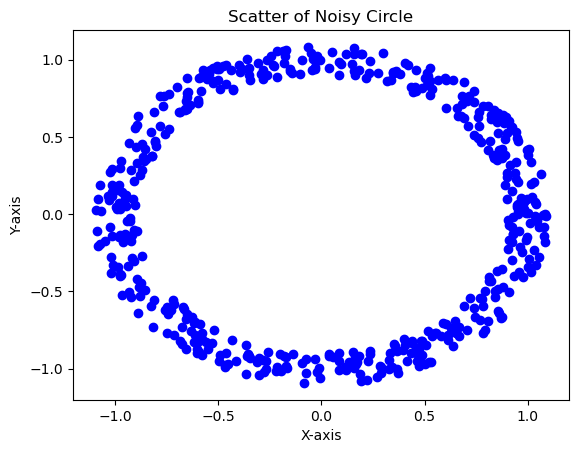

In [1688]:
# Create a plot
plt.scatter(x, y, label='circle', color='b')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter of Noisy Circle')

# Show the plot
plt.show()


In [1689]:
# Convert to PyTorch tensors
X_train = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)  # Input: x (Shape: [num_samples, 1])
Y_train = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)  # Output: y (Shape: [num_samples, 1])

# Create class for Mixture Density Network

In [1690]:
class MDN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gaussians):
        super(MDN, self).__init__()
        self.num_gaussians = num_gaussians
        self.hidden = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Sigmoid(), #The paper uses Simoid, but ReLU seems to work better in this case
            nn.ReLU(),
            
            # Generally doesn't need it, but bad results less likely when present
            nn.Linear(hidden_dim, hidden_dim),
            # nn.Sigmoid()
            nn.ReLU()

            # nn.Linear(hidden_dim, hidden_dim),
            # # nn.Sigmoid()
            # nn.ReLU()
            
        )
        self.alpha = nn.Linear(hidden_dim, num_gaussians)   # Mixing coefficients
        self.mu = nn.Linear(hidden_dim, num_gaussians * output_dim)  # Means
        self.sigma = nn.Linear(hidden_dim, num_gaussians * output_dim)  # Standard deviations

    def forward(self, x):
        h = self.hidden(x)
        alpha = torch.softmax(self.alpha(h), dim=1)  # Softmax for mixing coefficients
        mu = self.mu(h).view(-1, self.num_gaussians, 1)  # Reshape to (batch, gaussians, output_dim)
        sigma = torch.exp(self.sigma(h)).view(-1, self.num_gaussians, 1)  # Ensure positive values
        return alpha, mu, sigma

In [1691]:
# Define loss function for MDN
def mdn_loss(alpha, mu, sigma, y):
    """
    Computes the negative log-likelihood loss for the Mixture Density Network.
    """
    y = y.unsqueeze(1).expand_as(mu)  # Expand y to match Gaussian components
    prob_density = (1 / (sigma * np.sqrt(2 * np.pi))) * torch.exp(-0.5 * ((y - mu) / sigma) ** 2)
    
    # Fix: Sum over the last dimension before multiplying with alpha
    prob_density = torch.prod(prob_density, dim=2)  # Now (batch_size, num_gaussians)
    
    weighted_prob = torch.sum(alpha * prob_density, dim=1)  # Now (batch_size,)
    loss = -torch.log(weighted_prob + 1e-8).mean()  # Add small value for numerical stability
    return loss

# More constants for the model and initialize the model

In [1692]:
# Initialize the model
input_dim = 1  # Only x is given as input
output_dim = 1  # Predicts y
num_gaussians = 2  # Two Gaussians

#consistently bad results with 1, sometimes bad reults with 2,4,16,32
hidden_dim = 128
model = MDN(input_dim, hidden_dim, output_dim, num_gaussians)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [1693]:
# Training Loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    alpha, mu, sigma = model(X_train)
    loss = mdn_loss(alpha, mu, sigma, Y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [0/1000], Loss: 1.1631
Epoch [100/1000], Loss: 0.8507
Epoch [200/1000], Loss: -0.3193
Epoch [300/1000], Loss: -0.3341
Epoch [400/1000], Loss: -0.3376
Epoch [500/1000], Loss: -0.3419
Epoch [600/1000], Loss: -0.3473
Epoch [700/1000], Loss: -0.3534
Epoch [800/1000], Loss: -0.3649
Epoch [900/1000], Loss: -0.3670


In [1694]:
# X_train = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)  # Input: x (Shape: [num_samples, 1])
# Y_train = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)  # Output: y (Shape: [num_samples, 1])

# alpha, mu, sigma = model(X_train)
# y = Y_train

# y = y.unsqueeze(1).expand_as(mu)  # Expand y to match Gaussian components

# print(type(y))
# prob_density = (1 / (sigma * np.sqrt(2 * np.pi))) * torch.exp(-0.5 * ((y - mu) / sigma) ** 2)

# # Fix: Sum over the last dimension before multiplying with alpha
# prob_density = torch.prod(prob_density, dim=2)  # Now (batch_size, num_gaussians)

# weighted_prob = torch.sum(alpha * prob_density, dim=1)  # Now (batch_size,)
# loss = -torch.log(weighted_prob + 1e-8).mean()  # Add small value for numerical stability

In [1695]:
# Define the heatmap grid
x_range = np.linspace(x_min, x_max, 500)
y_range = np.linspace(y_min, y_max, 500)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])  # Shape: (10000, 2)

In [1696]:
# Convert grid points to PyTorch tensor
X_test = torch.tensor(grid_points[:, 0].reshape(-1, 1), dtype=torch.float32)  # Use only x

In [1697]:
# Get MDN predictions
with torch.no_grad():
    pi, mu, sigma = model(X_test)  # Get MDN parameters

In [1698]:
# Compute probability densities for each (x, y) pair in the grid
def compute_mdn_pdf(pi, mu, sigma, y_grid):
    """
    Computes the probability density of y given x using the mixture of Gaussians.
    """
    y_tensor = torch.tensor(y_grid.reshape(-1, 1, 1), dtype=torch.float32)  # Shape: (grid_size, 1, 1)
    prob_density = (1 / (sigma * np.sqrt(2 * np.pi))) * torch.exp(-0.5 * ((y_tensor - mu) / sigma) ** 2)
    prob_density = torch.prod(prob_density, dim=2)  # Shape: (grid_size, num_gaussians)
    weighted_prob = torch.sum(pi * prob_density, dim=1)  # Final probability per point
    return weighted_prob.numpy().reshape(X_grid.shape)

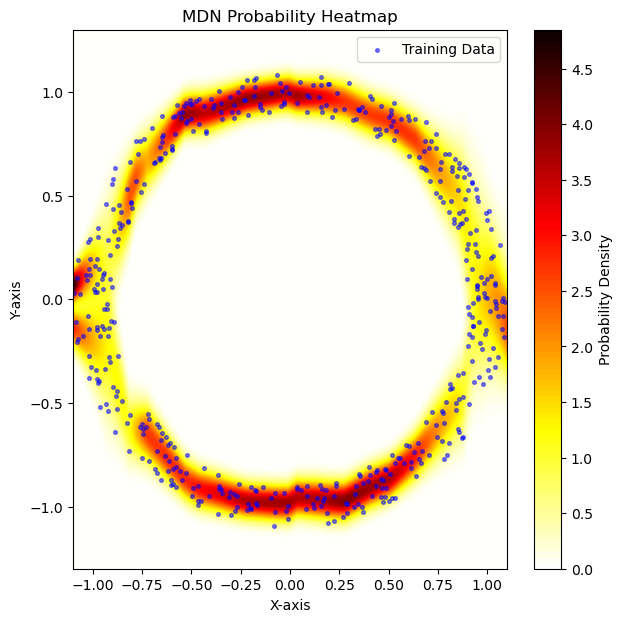

In [1699]:
# Compute probability density for each (x, y) in the grid
heatmap_values = compute_mdn_pdf(pi, mu, sigma, grid_points[:, 1])

# Use a perceptually uniform colormap (`inferno` or `hot_r`)
plt.figure(figsize=(7, 7))
contour = plt.contourf(X_grid, Y_grid, heatmap_values, levels=100, cmap="hot_r")  # `hot_r` also works well

# Add colorbar
cbar = plt.colorbar(contour)
cbar.set_label('Probability Density')

# Change xlim
plt.xlim(-1.1, 1.1)

# Labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('MDN Probability Heatmap')

# Plot training points for reference
plt.scatter(x, y, color='blue', alpha=0.5, s=7, label='Training Data')
plt.legend()
plt.show()

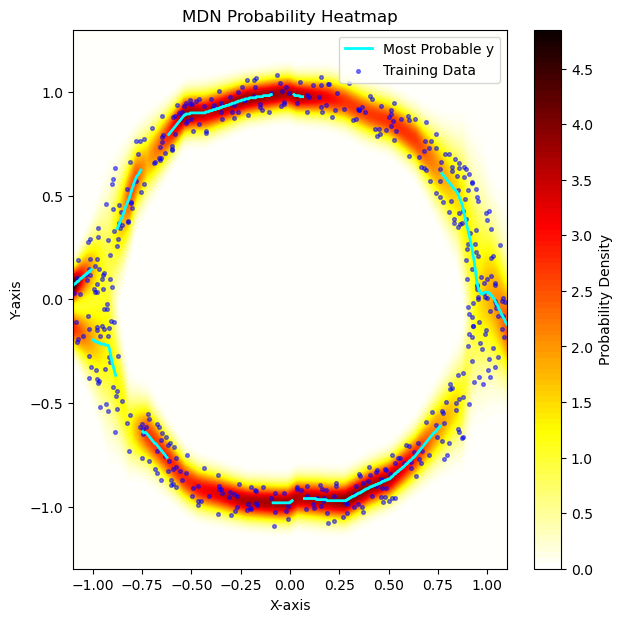

In [1700]:
# Compute probability density for each (x, y) in the grid
heatmap_values = compute_mdn_pdf(pi, mu, sigma, grid_points[:, 1])

# Find the most probable y values for each x (taking the absolute max)
y_max_prob_indices = np.argmax(heatmap_values, axis=0)  # Max value index per x
y_mode = y_range[y_max_prob_indices]  # Map indices back to y values

# Define a threshold for acceptable y jumps
jump_threshold = 0.2  # Adjust this to remove discontinuities

# Create the figure
plt.figure(figsize=(7, 7))

# Plot the heatmap first
contour = plt.contourf(X_grid, Y_grid, heatmap_values, levels=100, cmap="hot_r")

# Add colorbar
cbar = plt.colorbar(contour)
cbar.set_label('Probability Density')

# Overlay the most probable y values as a smooth segmented line
valid_x, valid_y = [], []
for i in range(1, len(x_range)):
    if np.abs(y_mode[i] - y_mode[i - 1]) < jump_threshold:
        valid_x.append(x_range[i])
        valid_y.append(y_mode[i])
    else:
        # Plot the current segment and start a new one
        if len(valid_x) > 1:
            plt.plot(valid_x, valid_y, color='cyan', linewidth=2)
        valid_x, valid_y = [], []  # Reset for next segment

# Plot the last segment if valid
if len(valid_x) > 1:
    plt.plot(valid_x, valid_y, color='cyan', linewidth=2, label='Most Probable y')

# Change xlim
plt.xlim(-1.1, 1.1)

# Labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('MDN Probability Heatmap')

# Plot training points for reference
plt.scatter(x, y, color='blue', alpha=0.5, s=7, label='Training Data')

# Show legend
plt.legend()
plt.show()


In [1701]:
x_test_values = np.linspace(-1.2, 1.2, 500).reshape(-1, 1)
X_test_tensor = torch.tensor(x_test_values, dtype=torch.float32)

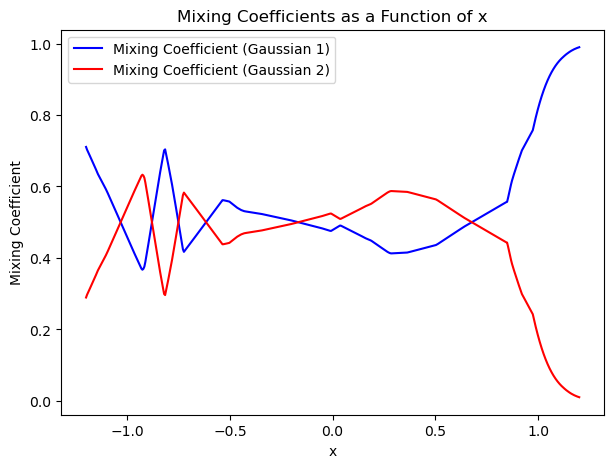

In [1702]:
# More plots
# Compute mixing coefficients for a 1D range of x values
with torch.no_grad():
    pi_test, _, _ = model(X_test_tensor)  # Predict only pi

# Convert to NumPy
pi_test_np = pi_test.numpy()

# Ensure the shapes match for plotting
x_test_values = x_test_values.flatten()  # Flatten x_test_values from (100,1) to (100,)

# Plot the mixing coefficients as a function of x
plt.figure(figsize=(7, 5))
plt.plot(x_test_values, pi_test_np[:, 0], label="Mixing Coefficient (Gaussian 1)", color='blue')
plt.plot(x_test_values, pi_test_np[:, 1], label="Mixing Coefficient (Gaussian 2)", color='red')
plt.xlabel("x")
plt.ylabel("Mixing Coefficient")
plt.title("Mixing Coefficients as a Function of x")
plt.legend()
plt.show()


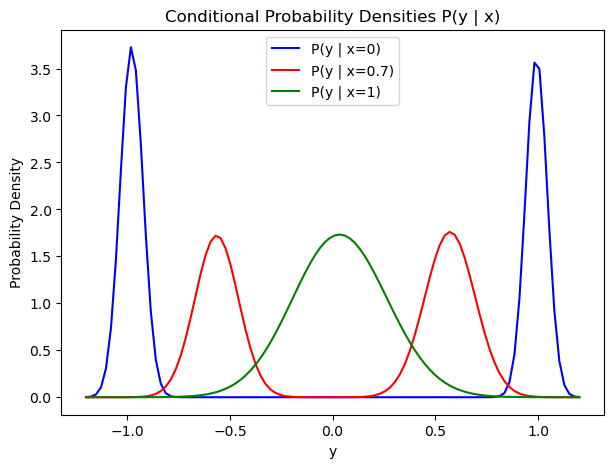

In [1703]:
# Function to compute probability density for specific x values
def compute_mdn_pdf_for_x(model, x_value):
    x_tensor = torch.tensor([[x_value]], dtype=torch.float32)
    with torch.no_grad():
        alpha, mu, sigma = model(x_tensor)
    
    y_values = np.linspace(-1.2, 1.2, 100)
    y_tensor = torch.tensor(y_values.reshape(-1, 1, 1), dtype=torch.float32)
    
    prob_density = (1 / (sigma * np.sqrt(2 * np.pi))) * torch.exp(-0.5 * ((y_tensor - mu) / sigma) ** 2)
    prob_density = torch.prod(prob_density, dim=2)
    weighted_prob = torch.sum(alpha * prob_density, dim=1)
    
    return y_values, weighted_prob.numpy()

# Compute probability density for x = 0 and x = 0.8
y_values_0, pdf_0 = compute_mdn_pdf_for_x(model, 0)
# y_values_07, pdf_07 = compute_mdn_pdf_for_x(model, 0.7)
y_values_08, pdf_08 = compute_mdn_pdf_for_x(model, 0.8)
y_values_1, pdf_1 = compute_mdn_pdf_for_x(model, 1)

# Plot probability densities
plt.figure(figsize=(7, 5))
plt.plot(y_values_0, pdf_0, label="P(y | x=0)", color='blue')
# plt.plot(y_values_07, pdf_07, label="P(y | x=0.7)", color='red')
plt.plot(y_values_08, pdf_08, label="P(y | x=0.7)", color='red')
plt.plot(y_values_1, pdf_1, label="P(y | x=1)", color='green')
plt.xlabel("y")
plt.ylabel("Probability Density")
plt.title("Conditional Probability Densities P(y | x)")
plt.legend()
plt.show()